# AWS re:Invent Machine Learning Builders' Session

#### WPS302: Identify improper payments with analytics and ML (Lab 2)

---

## Introduction
#### Since 2003, the US federal government has made approximately $\$$1.7 trillion in improper payments, with an estimated $\$$206 billion made in FY 2020 alone. Improper payments are now anticipated to increase proportionally to new levels of federal spending, from the $\$$1 trillion infrastructure bill, to the anticipated $\$$3.5 trillion budget reconciliation plan.

#### *How can we go beyond basic heuristic rulesets to help agencies identify improper payments at scale?*

#### **In this lab we'll demonstrate how to train a classification model on an imbalanced dataset to predict fraudulent Medicare providers using the RandomCutForest algorithm. Additionally, we'll demonstrate using Script Mode and a Batch Transform.**

</p>

#### **Let's get started!**

---

## 1. Setup
<a id=section_1_0></a>

### 1.1 Prerequisites
<a id=section_1_1></a>

In [35]:
!pip install imblearn
# !pip install sagemaker
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


### 1.2 Import packages and modules
<a id=section_1_2></a>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# AWS SDK for Python and Sagemaker packages
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

from math import sqrt

# Imbalanced-learn packages
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# sklearn packages
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score, 
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,    
    plot_confusion_matrix,
    roc_auc_score
)

%matplotlib inline

### 1.3 Global config settings
<a id=section_1_3></a>

In [37]:
# Set lab name
lab_name = 'lab2'

# Allow viewing of all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create directory to store lab contents
data_dir = './data/{}'.format(lab_name)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

### 1.4 Global config variables
<a id=section_1_4></a>

In [ ]:
# Get the IAM role and Sagemaker session
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

# Get the SakeMaker session
session = sagemaker.Session()

print('Using IAM role arn: {}'.format(role))

In [39]:
# Setup the S3 client
s3_client = boto3.client('s3')

# Set S3 settings
bucket = session.default_bucket()
prefix = 'fraud-detect-demo'

print('Using S3 path: s3://{}/{}'.format(bucket, prefix))

Using S3 path: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo


## 2. Exploratory Data Analysis
<a id=section_2_0></a>

### 2.1 Read the preprocessed medicare data
<a id=section_2_1></a>

In [40]:
data = pd.read_csv('./data/processed_data_classification_v2.csv', delimiter=',')

### 2.2 View the dimensions of the dataset (#rows, #cols)
<a id=section_2_2></a>

In [41]:
data.shape

(5500, 50)

### 2.3 Visually inspect the first few rows in the dataset
<a id=section_2_3></a>

In [42]:
data.head()

,fraudulent_provider,female,tot_suplrs_standard_deviation,tot_suplrs_mean,tot_suplrs_sum,tot_suplr_benes_standard_deviation,tot_suplr_benes_mean,tot_suplr_benes_sum,tot_suplr_clms_standard_deviation,tot_suplr_clms_mean,tot_suplr_clms_sum,tot_suplr_srvcs_standard_deviation,tot_suplr_srvcs_mean,tot_suplr_srvcs_sum,avg_suplr_sbmtd_chrg_standard_deviation,avg_suplr_sbmtd_chrg_mean,avg_suplr_sbmtd_chrg_sum,avg_suplr_mdcr_pymt_amt_standard_deviation,avg_suplr_mdcr_pymt_amt_mean,avg_suplr_mdcr_pymt_amt_sum,bene_unique_cnt_mean,bene_unique_cnt_sum,bene_unique_cnt_standard_deviation,line_svc_cnt_mean,line_svc_cnt_sum,line_svc_cnt_standard_deviation,bene_day_srvc_cnt_mean,bene_day_srvc_cnt_sum,bene_day_srvc_cnt_standard_deviation,average_submitted_chrg_amt_mean,average_submitted_chrg_amt_sum,average_submitted_chrg_amt_standard_deviation,average_medicare_payment_amt_mean,average_medicare_payment_amt_sum,average_medicare_payment_amt_standard_deviation,total_claim_count_mean,total_claim_count_sum,total_claim_count_standard_deviation,total_30_day_fill_count_mean,total_30_day_fill_count_sum,total_30_day_fill_count_standard_deviation,total_day_supply_mean,total_day_supply_sum,total_day_supply_standard_deviation,total_drug_cost_mean,total_drug_cost_sum,total_drug_cost_standard_deviation,bene_count_mean,bene_count_sum,bene_count_standard_deviation
0,0,0,0,2,12,0,5,30,8,26,157,8,26,157,221.545084,281.291774,1687.750642,40.267402,51.756601,310.539608,61,2019,45,87,2894,97,87,2894,97,612.122842,20200.053790,276.195300,83.302926,2748.996574,33.577014,16,872,5,16.739623,887.2,6.144614,358,19016,225,679.101887,35992.40,1257.721840,7,400,4
1,0,1,3,4,390,8,11,1090,43,45,4214,1673,733,68183,648.536077,205.158603,19079.750090,126.268278,37.013509,3442.256332,74,13133,59,306,54166,457,199,35224,241,76.912131,13613.447170,65.999303,17.927735,3173.209053,21.273936,46,48942,53,62.092727,64886.9,75.053557,1709,1786163,2203,2399.843091,2507836.03,4524.335169,12,13508,14
2,0,1,4,4,290,5,7,423,20,25,1508,1745,706,41682,96.672171,79.101150,4666.967838,26.030407,21.551856,1271.559511,33,1128,25,67,2287,78,67,2287,78,133.688857,4545.421138,56.698190,67.149802,2283.093266,36.452336,50,48262,55,66.317066,63730.7,79.181677,1929,1854601,2389,2151.969084,2068042.29,4477.550876,11,11119,11
3,0,0,1,1,41,2,6,128,7,19,400,8,21,452,1483.976776,958.574271,20130.059680,879.222640,516.165752,10839.480790,130,31506,145,171,41456,232,160,38869,228,309.875494,74989.869460,326.187181,91.143027,22056.612430,79.139884,78,36671,101,175.826882,81759.5,255.800821,5220,2427675,7657,5472.788065,2544846.45,19909.428210,24,11364,32
4,0,0,4,4,333,9,9,677,25,35,2432,496,226,15402,168.249662,123.252361,8381.160563,53.286680,31.118151,2116.034257,83,11828,96,130,18498,218,129,18421,219,128.802917,18290.014170,158.839433,55.376012,7863.393671,59.656966,59,74114,71,100.573899,125616.8,148.234033,2858,3570133,4448,3955.478335,4940392.44,7644.742211,15,19910,18


### 2.4 Check data for any nulls
<a id=section_2_4></a>

In [43]:
data.isnull().values.any()

False

### 2.5 Check for imbalance
<a id=section_2_5></a>

Review the target (fraudulent_provider) value counts to check for imbalance

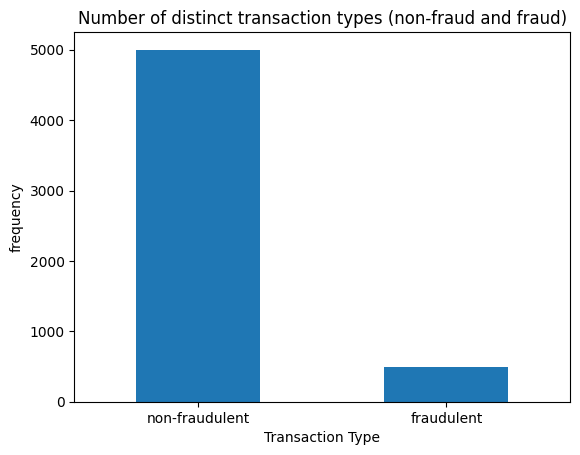

There are 5000 non-fradulent records and 500 fradulent records


In [44]:
fig, ax = plt.subplots()
data['fraudulent_provider'].value_counts().plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = 'Transaction Type')
plt.xticks(range(2), ['non-fraudulent', 'fraudulent'], rotation=0)
plt.title(label="Number of distinct transaction types (non-fraud and fraud)",
          fontsize=12,
          color="black")
plt.show()

print('There are {} non-fradulent records and {} fradulent records'.format(
    data['fraudulent_provider'].value_counts()[0], 
    data['fraudulent_provider'].value_counts()[1]))

We see that the majority of data is **non-fraudulent** transactions, however, our goal is to train a model to identify **fradulent** transactions. Attempting to train a model on this dataset (as-is) may yield a high accuracy score because accuracy is calculated as:

<pre>
Total Number of Correct Predictions / Total Number of Predictions
</pre>

As a result, the model will perform well when predicting the majority class, but perform poorly at predicting the minority class due to lack of training examples.

To address this challange, we will need to rebalance the dataset using sampling techniques that are designed to improve the performance of models that rely on imbalanced datasets. To help with this task, we'll use under and over sampling techniques from the [Imblearn package](https://imbalanced-learn.org/stable/user_guide.html#user-guide) 

## 3. Preprocessing
<a id=section_3_0></a>

### 3.1 Data Preparation
<a id=section_3_1></a>

Remove the column headers from the dataset as SageMaker does not need headers for processing CSV files

In [45]:
# Removing column headers from CSV file
feature_columns = data.columns[1:]
label_column = data.columns[0]

# Setting the datatype to float32
features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Split the dataset into train and test sets to evaluate the performance of our model

In [46]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.5, stratify=labels)

Since the data is highly imbalanced, it is important to stratify across the data sets to ensure a near even distribution, so we set the test_size parameter to 0.5. The training dataset (X_train) will be used to fit the model and the testing dataset (X_test) will be used for predictions

Display the size of the training and test datasets after the train-test split

In [47]:
print('The training dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(y_train), (y_train == 0).sum(), (y_train == 1).sum()))
print('The test dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(y_test), (y_test == 0).sum(), (y_test == 1).sum()))

The training dataset contains 2750 total rows (2500 non-fraudulent transactions, 250 fraudulent transactions)
The test dataset contains 2750 total rows (2500 non-fraudulent transactions, 250 fraudulent transactions)


### 3.2 Applying Synthetic Minority Over-sampling (SMOTE)
<a id=section_3_2></a>

The [sampling strategy](https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html#sphx-glr-auto-examples-api-plot-sampling-strategy-usage-py) for resampling an imbalanced dataset is very important for improving the performance of the model. 

For this lab, we'll set the [SMOTE sampling strategy](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) to 0.95, which means SMOTE will create new samples until the minority class is equal to 95% of the majority class (2500 * 0.95 = 2375). Next, we'll set the [RandomUnderSampler sampling strategy](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) to 1.0, which means we'll reduce the number of samples in the majority class (2500) to equal the new minority class size (2375).

Feel free to expirement with different sampling strategy ratios to see the impact.

In [48]:
# Oversample the minority class with SMOTE 
over = SMOTE(random_state=42, sampling_strategy=0.95)

# Undersample the majority class to achieve about a 1:1 ratio.
# The minority class will be the same amount (1 to 1) as the majority class
under = RandomUnderSampler(random_state=42, sampling_strategy=1.0)

# Add steps to parameter list
steps = [('o', over), ('u', under)]

# Create imblearn.pipeline and pass steps
pipeline = Pipeline(steps=steps)

# Fit and apply to the CMS dataset in a single transform
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

### 3.3 Check for imbalance
<a id=section_3_3></a>

Review the target (fraudulent_provider) value counts to check for imbalance *after* applying data augmentation

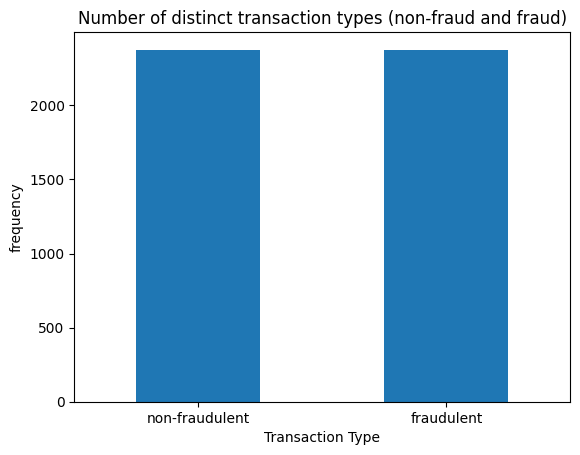

There are 2375 non-fradulent records and 2375 fradulent records


In [49]:
# Convert to DataFrame for plotting
df_y_smote = pd.DataFrame(y_smote.astype(int))

# Plot
fig, ax = plt.subplots()
df_y_smote.value_counts().plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = 'Transaction Type')
plt.xticks(range(2), ['non-fraudulent', 'fraudulent'], rotation=0)
plt.title(label="Number of distinct transaction types (non-fraud and fraud)",
          fontsize=12,
          color="black")
plt.show()

print('There are {} non-fradulent records and {} fradulent records'.format(
    df_y_smote.value_counts()[0], 
    df_y_smote.value_counts()[1]))

In [50]:
pct_chg = abs((len(df_y_smote) - len(data)) / len(data) * 100)

print('Observe that by applying SMOTE and RandomUnderSampling our dataset has decreased in size by {:.2f}% as a result of downsampling of the majority class and upsampling of the minority class'.format(pct_chg))

Observe that by applying SMOTE and RandomUnderSampling our dataset has decreased in size by 13.64% as a result of downsampling of the majority class and upsampling of the minority class


### 3.4 Test-train split for augmented dataset
<a id=section_3_4></a>

Split the resampled dataset - 80% will be used for training and 20% will be used for validation

In [51]:
X_smote_train, X_smote_validation, y_smote_train, y_smote_validation = train_test_split(
    X_smote, y_smote, test_size=0.2, stratify=y_smote)

Display the size of the training and test datasets after the train-test split

In [52]:
print('The training dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(X_smote_train), (y_smote_train == 0).sum(), (y_smote_train == 1).sum()))
print('The validation dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(X_smote_validation), (y_smote_validation == 0).sum(), (y_smote_validation == 1).sum()))

The training dataset contains 3800 total rows (1900 non-fraudulent transactions, 1900 fraudulent transactions)
The validation dataset contains 950 total rows (475 non-fraudulent transactions, 475 fraudulent transactions)


### 3.5 Prepare datasets for training and evaluation

Ensure the first column in the dataset are the labels, then convert to DataFrames. We'll use the training and validation datasets (which we have over and undersampled) for training the model. We'll use the testing dataset for model evaluation. 

In [53]:
# Rearrange the first column as target column
trainX_concate = np.concatenate((y_smote_train.reshape(len(y_smote_train),1), X_smote_train), axis=1)
trainX = pd.DataFrame(trainX_concate, index=None, columns=None)

validationX_concate = np.concatenate((y_smote_validation.reshape(len(y_smote_validation),1), X_smote_validation), axis=1)
validationX = pd.DataFrame(validationX_concate, index=None, columns=None)

testX = pd.DataFrame(X_test, index=None, columns=None)

Save the files locally in CSV format. After this step, there should be three new CSV files visible in the folder: **./data/lab2**

In [54]:
trainX.to_csv("{}/train.csv".format(data_dir), header=False, index=False)
validationX.to_csv("{}/validation.csv".format(data_dir), header=False, index=False)
testX.to_csv("{}/test.csv".format(data_dir), header=False, index=False)

### 3.6 Upload the datasets to S3

In [55]:
# Set the directory path in S3
subdir = '{}/smote'.format(lab_name)

train_path = session.upload_data(
    path="{}/train.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/training'.format(prefix, subdir)
)

validation_path = session.upload_data(
    path="{}/validation.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/validation'.format(prefix, subdir)
)

test_path = session.upload_data(
    path="{}/test.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/testing'.format(prefix, subdir)
)

Display the location of our datasets in S3

In [56]:
print('The S3 URI of the training dataset is: {}'.format(train_path))
print('The S3 URI of the validation dataset is: {}'.format(validation_path))
print('The S3 URI of the testing dataset is: {}'.format(test_path))

The S3 URI of the training dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab2/smote/training/train.csv
The S3 URI of the validation dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab2/smote/validation/validation.csv
The S3 URI of the testing dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab2/smote/testing/test.csv


### 3.7 Set the output location for model artifacts in S3

In [57]:
output_location = 's3://{}/{}/{}/output/'.format(bucket, prefix, subdir)
print('The S3 URI for model artifacts is: {}'.format(output_location))

The S3 URI for model artifacts is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab2/smote/output/


## 4. Model Training
<a id=section_4_0></a>

### 4. Writing a *Script Mode* script
<a id=section_4_1></a>

The below script contains both training and inference functionality and can run in SageMaker Training hardware. Detailed guidance here https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script

In [58]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# inference function for model loading
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="validation.csv")

    args, _ = parser.parse_known_args()
    
    # read data from csv
    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file), header=None)
    test_df = pd.read_csv(os.path.join(args.test, args.test_file), header=None)

    # build training and testing dataset
    print("building training and testing datasets")
    X_train = train_df[train_df.columns[1:]]
    X_test = test_df[test_df.columns[1:]]
    y_train = train_df[train_df.columns[0]]
    y_test = test_df[test_df.columns[0]]

    # train
    print("training model")
    model = RandomForestClassifier(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print accuracy
    print("validating model")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy is: {acc}")
    print(f"Area under the curve is: {auc}")

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Writing script.py


### 4.2 SageMaker Training
<a id=section_4_2></a>

Launching a training job with SageMaker Python SDK

In [59]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"}],
    output_path=output_location,
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 2
    }
)

**Note: This step will initiate a Sagemaker Training Job and will take approximately 2-3 minutes to complete. As the Sagemaker Training Job is running there will be a lot of logging data generated, this is normal. The job is successfully completed when you see output similar to the following:**
<pre>
...
yyyy-mm-dd HH:mm:ss Completed - Training job completed
...
Training seconds: 77
Billable seconds: 77
</pre>

In [60]:
# kick off training job
sklearn_estimator.fit({"train": train_path, "test": validation_path}, wait=True)

2022-11-11 16:36:08 Starting - Starting the training job...
2022-11-11 16:36:35 Starting - Preparing the instances for trainingProfilerReport-1668184568: InProgress
.........
2022-11-11 16:38:08 Downloading - Downloading input data...
2022-11-11 16:38:44 Training - Training image download completed. Training in progress.
2022-11-11 16:38:44 Uploading - Uploading generated training model
2022-11-11 16:38:44 Completed - Training job completed
2022-11-11 16:38:24,341 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-11 16:38:24,343 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-11 16:38:24,351 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-11 16:38:24,553 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-11 16:38:24,563 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-11 16:38:24,573

## 5. Model Hosting
<a id=section_5_0></a>

We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

### 5.1 Define an SKLearn Transformer from the trained SKLearn Estimator
<a id=section_5_1></a>

In [61]:
transformer = sklearn_estimator.transformer(instance_count=1, instance_type="ml.m5.xlarge", strategy='MultiRecord', assemble_with="Line", accept="text/csv", 
                                            output_path=output_location)

Now we deploy the estimator to an endpoint.

### 5.2 Start a batch transform job and wait for it to finish
<a id=section_5_2></a>

**Note: This step will create a batch transform job and will take approximately 3-4 minutes to complete. As the batch transform job is running there will be a lot of logging data generated, this is normal.**

In [62]:
transformer.transform(test_path, split_type="Line", content_type="text/csv")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

...........................
2022-11-11 16:43:23,191 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-11 16:43:23,193 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-11 16:43:23,194 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
2022-11-11 16:43:23,191 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-11 16:43:23,193 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-11 16:43:23,194 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    

After the transform job has completed, download the output data from S3. For each file "f" in the input data, we have a corresponding file "f.out" containing the predicted labels from each input row. We can compare the predicted labels to the true labels saved earlier.

## 6. Model Evaluation
<a id=section_6_0></a>

### 6.1 Download the output data from S3 to local file system
<a id=section_6_1></a>

In [63]:
batch_output = transformer.output_path
output_file_name = "test.csv.out"

!aws s3 cp {batch_output}{output_file_name} {data_dir}

Completed 10.7 KiB/10.7 KiB (42.2 KiB/s) with 1 file(s) remaining
download: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab2/smote/output/test.csv.out to data\lab2\test.csv.out


### 6.2 Get output predictions
<a id=section_6_2></a>

In [64]:
from numpy import genfromtxt
y_preds = genfromtxt(data_dir + '/' + output_file_name, delimiter=',') 
y_preds.shape

(2750,)

### 6.3 Calculate balanced accuracy scores
<a id=section_6_3></a>

In [65]:
# Calculate balanced accuracy score
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))

Balanced accuracy = 0.7136


### 6.4 Plot results in a confusion matrix
<a id=section_6_4></a>

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, per-class precision, recall and f1-scores can also provide more information about the model's performance.

In [66]:
def plot_confusion_matrix(y_true, y_predicted):

    cm = confusion_matrix(y_true, y_predicted, labels=[0, 1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-fraud", "fraud"])
    disp.plot()

    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    plt.show()

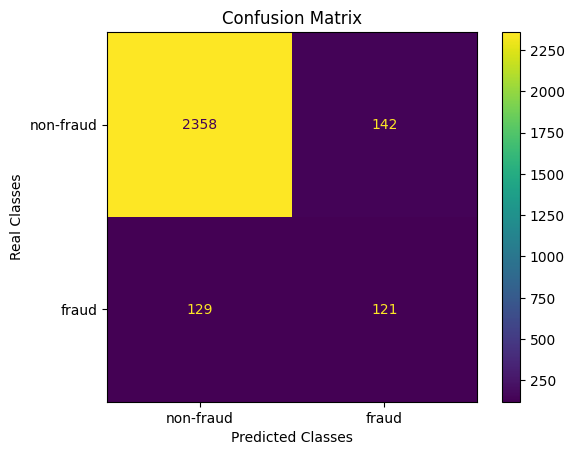

In [67]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_preds)

### 6.5 Display Classification Report
<a id=section_6_5></a>

In [68]:
print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       0.95      0.94      0.95      2500
       fraud       0.46      0.48      0.47       250

    accuracy                           0.90      2750
   macro avg       0.70      0.71      0.71      2750
weighted avg       0.90      0.90      0.90      2750



### Clean up

### Data Acknowledgements

The curated dataset used for this lab comes from the following Centers for Medicare & Medicaid Services dataset:
https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service